In [3]:
# Import the necessary libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,PrecisionRecallDisplay,classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from transformers import RobertaTokenizer, TFRobertaModel,TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
# Install text hammer for cleaning the data
!pip install text_hammer
import text_hammer as th

In [4]:
#Read the csv file
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')



## Exploratory analysis of data

In [ ]:
df.head()

In [ ]:
#Plotting the distribution of the sentiments to get an idea of imbalance of classes in the dataset
plt.hist(df.sentiment)
plt.plot()

In [ ]:
#Checking for missing values in the dataset
print('Number of missing values in the dataset:',df.isna().sum())

## Data processing 

In [ ]:
#Encode the sentiments 
df.loc[df['sentiment']=='positive','sentiment']=1
df.loc[df['sentiment']=='negative','sentiment']=0

In [ ]:
#Using Text-Hammer library to clean the dataset
def text_preprocessing(df,col):
    df[col] = df[col].apply(lambda x:str(x).lower()) # lower case
    df[col] = df[col].apply(lambda x: th.cont_exp(x)) #complete the shortned words: you're -> you are
    df[col] = df[col].apply(lambda x: th.remove_emails(x)) # remove emails (having them in IMDB reviews is unnecesssary)
    df[col] = df[col].apply(lambda x: th.remove_html_tags(x)) #remove HTML tags
    df[col] = df[col].apply(lambda x: th.remove_special_chars(x)) # remove special characters
    df[col] = df[col].apply(lambda x: th.remove_accented_chars(x))#remove symbols that indicate pronunciation
    return df
df_cleaned = text_preprocessing(df,'review')

## Creating the dataset for training and testing

In [ ]:
#Splitting the cleaned dataset into train, validation and test sets
df_train,df_val = train_test_split(df_cleaned,test_size=0.2,stratify=df_cleaned['sentiment'])
df_val,df_test = train_test_split(df_val,test_size=0.2,stratify=df_val['sentiment'])
# df_cleaned.to_csv('clean_.csv')  for saving the dataset

In [ ]:
#To get an idea of the length of the sentences so that we can set a limit while tokenization
plt.hist([len(x.split()) for x in df_cleaned.review],bins=100)
plt.show()

In [5]:
#Initialize the tokenier with "RoBerta Base"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
#Using the tokenizer to tokenize the train, validation and test sets
x_train = tokenizer(text = df_train.review.tolist(), #convert the pandas series to list
                    add_special_tokens = True, 
                    max_length = 450, #max length determined by the graph above
                    truncation= True, 
                    padding =True, 
                    return_tensors = 'tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)
x_val = tokenizer(text = df_val.review.tolist(), 
                    add_special_tokens = True, 
                    max_length = 450, 
                    truncation= True, 
                    padding =True, 
                    return_tensors = 'tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)
x_test = tokenizer(text = df_test.review.tolist(), 
                    add_special_tokens = True, 
                    max_length = 450, 
                    truncation= True, 
                    padding =True, 
                    return_tensors = 'tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)

In [ ]:
#Convert target values to tensor
y_train=tf.convert_to_tensor(df_train.sentiment.values.astype('int32'))
y_train=np.expand_dims(y_train,axis=1)

y_val=tf.convert_to_tensor(df_val.sentiment.values.astype('int32'))
y_val=np.expand_dims(y_val,axis=1)

y_test=tf.convert_to_tensor(df_test.sentiment.values.astype('int32'))
y_test=np.expand_dims(y_test,axis=1)

In [ ]:
#Create Tensorflow dataset to get maximum benefit out of hardware
#We used cache for storing the data into memory, thus providing faster loading time
train_dataset=tf.data.Dataset.from_tensor_slices(({'input_ids':x_train['input_ids'], 
                                                   'attention_mask':x_train['attention_mask']},
                                                  y_train)).batch(batch_size=8, drop_remainder=True,
                                                                  num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
val_dataset=tf.data.Dataset.from_tensor_slices(({'input_ids':x_val['input_ids'], 
                                                   'attention_mask':x_val['attention_mask']},
                                                  y_val)).batch(batch_size=8, drop_remainder=True,
                                                                  num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

## Model Training

In [8]:
#We trained on Kaggle mult-GPU(two T4 GPU's), so we use mirrored_strategy for data parellelization 
mirrored_strategy = tf.distribute.MirroredStrategy()
#Define the model inside mirrored_strategy.scope() 
with mirrored_strategy.scope():
    model = TFRobertaModel.from_pretrained("roberta-base",num_labels=2)
    input_ids = Input(shape=(450,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(450,), dtype=tf.int32, name="attention_mask")
    embeddings = model(input_ids, attention_mask = input_mask)[0]
    print(embeddings,embeddings.shape)# 0 = last hidden state, 1 = poller_output
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = Dense(32, activation='relu')(out)
    y = Dense(1, activation='sigmoid')(out)
    model_class = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
#Set "tf_roberta_model" layer as trainable
model_class.layers[2].trainable = True
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
#We use Binary Crossentropy as we have 2 target classes
model_class.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


#We use Early Stopping callback
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

#Fit the model
hist = model_class.fit(train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size=16,
    callbacks=[callback])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 450, 768), dtype=tf.float32, name=None), name='tf_roberta_model_2/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_roberta_model_2'") (None, 450, 768)


2023-01-04 16:10:27.651513: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "ParallelBatchDataset/_7"
op: "ParallelBatchDataset"
input: "TensorSliceDataset/_3"
input: "Const/_4"
input: "Const/_11"
input: "Const/_6"
attr {
  key: "deterministic"
  value {
    s: "default"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
        dim {
          size: 450
        }
      }
      shape {
        dim {
          size: 8
        }
        dim {
          size: 450
        }
      }
      shape {
        dim {
          size: 8
        }
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
 

Epoch 1/5
5000/5000 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9166

2023-01-04 16:58:12.286455: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "ParallelBatchDataset/_7"
op: "ParallelBatchDataset"
input: "TensorSliceDataset/_3"
input: "Const/_4"
input: "Const/_5"
input: "Const/_6"
attr {
  key: "deterministic"
  value {
    s: "default"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
        dim {
          size: 450
        }
      }
      shape {
        dim {
          size: 8
        }
        dim {
          size: 450
        }
      }
      shape {
        dim {
          size: 8
        }
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
  

5000/5000 [==============================] - 3012s 595ms/step - loss: 0.2241 - accuracy: 0.9166 - val_loss: 0.2410 - val_accuracy: 0.9331
Epoch 2/5
5000/5000 [==============================] - 2974s 595ms/step - loss: 0.1809 - accuracy: 0.9387 - val_loss: 0.2120 - val_accuracy: 0.9329
Epoch 3/5
5000/5000 [==============================] - 2974s 595ms/step - loss: 0.1696 - accuracy: 0.9437 - val_loss: 0.2164 - val_accuracy: 0.9327
Epoch 4/5
5000/5000 [==============================] - 2972s 594ms/step - loss: 0.1676 - accuracy: 0.9451 - val_loss: 0.2413 - val_accuracy: 0.9355
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [9]:
#Saving the model weights
model_class.save('saved_model/my_model')

2023-01-04 19:29:37.015941: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Model Evaluation

In [16]:
#Evaluate model performance
print("Model Performance on test set")
result = model_class.evaluate({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']},y_test)
print(dict(zip(model_class.metrics_names, result)))

Model Performance on test set


2023-01-04 19:31:03.970180: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_288729"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

63/63 [==============================] - 42s 563ms/step - loss: 0.2181 - accuracy: 0.9275
{'loss': 0.21809877455234528, 'accuracy': 0.9275000095367432}


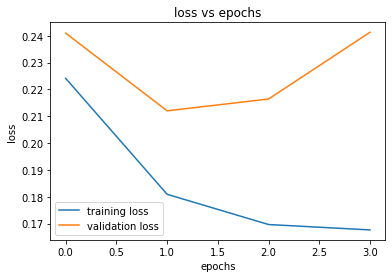

In [10]:
#Plotting the loss
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()
plot_graph(hist,'loss')

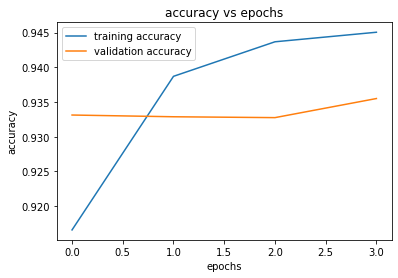

In [17]:
#Plotting the accuracy
plot_graph(hist,'accuracy')

In [11]:
#Getting the predictions on the test set
y_pred=model_class.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})
#using np.where to convert predicted values to 0 & 1
y_pred_label=np.where(y_pred>0.5,1,0)

2023-01-04 19:30:21.160619: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_282274"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

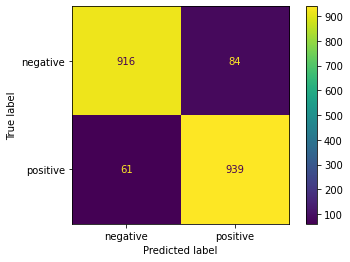

In [13]:
#Getting the confusion matrix and plotting it - We see that the model performs well and has very low false negatives and false positives
conf_matrix=confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=['negative','positive'])
disp.plot()
plt.show()

In [14]:
#We also try to look at other metrics using classification report
print(classification_report(y_test, y_pred_label, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.94      0.92      0.93      1000
    positive       0.92      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



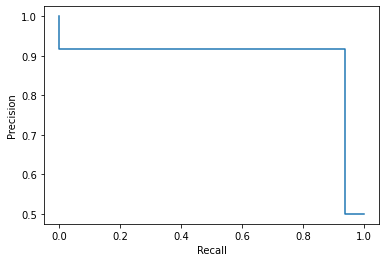

In [15]:
#We also plot the precision vs recall graph
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_label)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()